# Reclassifying data

Reclassifying data based on specific criteria is a common task when doing GIS
analysis. The purpose of this lesson is to see how we can reclassify values
based on some criteria. We could, for example, classify information based on
travel times and housing prices using these criteria:


1. if travel time to my work is less than 30 minutes, **AND**
2. the rent of the apartment is less than 1000 € per month

If both criteria are met: I go to see the appartment and try to rent it
If not: I continue to look for something else


In this tutorial, we will:

1. Use classification schemes from the PySAL [mapclassify
   library](https://pysal.org/mapclassify/) to classify travel times into
   multiple classes.

2. Create a custom classifier to classify travel times and distances in order
   to find out good locations to buy an apartment with these conditions:
   - good public transport accessibility to city center
   - bit further away from city center where the prices are presumably lower


## Input data

We will use [Travel Time Matrix data from
Helsinki](https://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix/)
that contains travel time and distance information for routes between all 250 m
x 250 m grid cell centroids (n = 13231) in the Capital Region of Helsinki by
walking, cycling, public transportation and car.

In [1]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [2]:
import geopandas
accessibility_grid = geopandas.read_file(
    DATA_DIRECTORY
    / "helsinki_region_travel_times_to_railway_station"
    / "helsinki_region_travel_times_to_railway_station.gpkg"
)
accessibility_grid.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,geometry
0,32297,43,32260,48,5785640,32616,116,147,32616,108,139,5975375,32164,459,"POLYGON ((382000 6697750, 381750 6697750, 3817..."
1,32508,43,32471,49,5785641,32822,119,145,32822,111,133,5975375,29547,422,"POLYGON ((382250 6697750, 382000 6697750, 3820..."
2,30133,50,31872,56,5785642,32940,121,146,32940,113,133,5975375,29626,423,"POLYGON ((382500 6697750, 382250 6697750, 3822..."
3,32690,54,34429,60,5785643,33233,125,150,33233,117,144,5975375,29919,427,"POLYGON ((382750 6697750, 382500 6697750, 3825..."
4,31872,42,31834,48,5787544,32127,109,126,32127,101,121,5975375,31674,452,"POLYGON ((381250 6697500, 381000 6697500, 3810..."


## Common classifiers

### Classification schemes for thematic maps

[PySAL](https://pysal.org/) -module is an extensive Python library for spatial
analysis. It also includes all of the most common data classifiers that are
used commonly e.g. when visualizing data. Available map classifiers in [pysal's
mapclassify -module](https://github.com/pysal/mapclassify):

- Box Plot
- Equal Interval
- Fisher Jenks
- Fisher Jenks Sampled
- HeadTail Breaks
- Jenks Caspall
- Jenks Caspall Forced
- Jenks Caspall Sampled
- Max P Classifier
- Maximum Breaks
- Natural Breaks
- Quantiles
- Percentiles
- Std Mean
- User Defined


There are plenty of different variables in the accessibility data set (see
[from here the
description](http://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix-2015)
for all attributes) but what we are interested in are columns called `pt_r_tt`
which is telling the time in minutes that it takes to reach city center from
different parts of the city, and `walk_d` that tells the network distance by
roads to reach city center from different parts of the city (almost equal to
Euclidian distance).

**The NoData values are presented with value -1**. 
Thus we need to remove the No Data values first.

In [3]:
# Include only data that is above or equal to 0
accessibility_grid = accessibility_grid.loc[accessibility_grid["pt_r_tt"] >=0]

Let's plot the data and see how it looks like
- `cmap` parameter defines the color map. Read more about [choosing colormaps in matplotlib](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
- `scheme` option scales the colors according to a classification scheme (requires `mapclassify` module to be installed):

c:\Users\mbi\AppData\Local\miniconda3\envs\autogis\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\mbi\AppData\Local\miniconda3\envs\autogis\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\mbi\AppData\Local\miniconda3\envs\autogis\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\mbi\AppData\Local\miniconda3\envs\autogis\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\mbi\AppData\Local\miniconda3\envs\autogis\lib\subprocess.py", line 145

<Axes: >

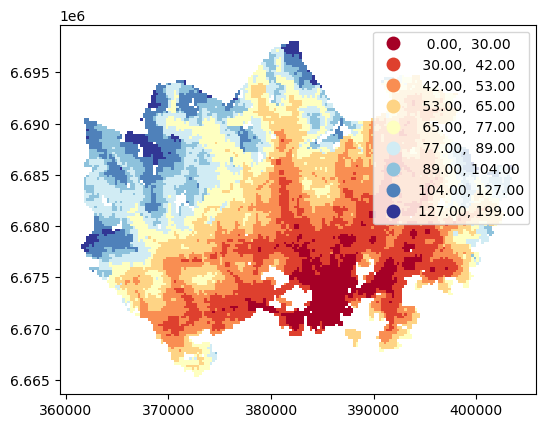

In [4]:
# Plot using 9 classes and classify the values using "Natural Breaks" classification
accessibility_grid.plot(column="pt_r_tt", scheme="Natural_Breaks", k=9, cmap="RdYlBu", linewidth=0, legend=True)

As we can see from this map, the travel times are lower in the south where the
city center is located but there are some areas of "good" accessibility also in
some other areas (where the color is red).

Let's also make a plot about walking distances:

<Axes: >

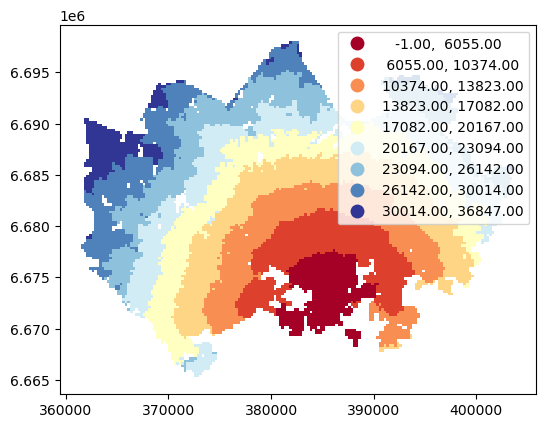

In [5]:
# Plot walking distance
accessibility_grid.plot(column="walk_d", scheme="Natural_Breaks", k=9, cmap="RdYlBu", linewidth=0, legend=True)

Okay, from here we can see that the walking distances (along road network)
reminds more or less Euclidian distances. 

### Applying classifiers to data

As mentioned, the `scheme` option defines the classification scheme using
`pysal/mapclassify`. Let's have a closer look at how these classifiers work.

In [6]:
import mapclassify

#### Natural Breaks

In [7]:
mapclassify.NaturalBreaks(y=accessibility_grid["pt_r_tt"], k=9)

NaturalBreaks

    Interval       Count
------------------------
[  0.00,  28.00] |   650
( 28.00,  41.00] |  2024
( 41.00,  53.00] |  2796
( 53.00,  65.00] |  2269
( 65.00,  76.00] |  1563
( 76.00,  88.00] |  1521
( 88.00, 103.00] |  1160
(103.00, 125.00] |   811
(125.00, 199.00] |   226

#### Quantiles (default is 5 classes):

In [8]:
mapclassify.Quantiles(y=accessibility_grid["pt_r_tt"])

Quantiles

    Interval       Count
------------------------
[  0.00,  41.00] |  2674
( 41.00,  52.00] |  2576
( 52.00,  66.00] |  2623
( 66.00,  85.00] |  2616
( 85.00, 199.00] |  2531

#### Extract threshold values

It's possible to extract the threshold values into an array:

In [9]:
classifier = mapclassify.NaturalBreaks(y=accessibility_grid["pt_r_tt"], k=9)
classifier.bins

array([ 29.,  41.,  52.,  64.,  77.,  92., 108., 129., 199.])

Let's apply one of the `Pysal` classifiers into our data and classify the
travel times by public transport into 9 classes
The classifier needs to be initialized first with `make()` function that takes
the number of desired classes as input parameter

In [10]:
# Create a Natural Breaks classifier
classifier = mapclassify.NaturalBreaks.make(k=9)

- Now we can apply that classifier into our data by using `apply` -function

In [11]:
# Classify the data
classifications = accessibility_grid[["pt_r_tt"]].apply(classifier)

# Let's see what we have
classifications.head()

,pt_r_tt
0,8
1,8
2,8
3,8
4,7


In [12]:
type(classifications)

pandas.core.frame.DataFrame

Okay, so now we have a DataFrame where our input column was classified into 9
different classes (numbers 1-9) based on [Natural Breaks
classification](http://wiki-1-1930356585.us-east-1.elb.amazonaws.com/wiki/index.php/Jenks_Natural_Breaks_Classification).

We can also add the classification values directly into a new column in our dataframe:

In [13]:
# Rename the column so that we know that it was classified with natural breaks
accessibility_grid["nb_pt_r_tt"] = accessibility_grid[["pt_r_tt"]].apply(classifier)

# Check the original values and classification
accessibility_grid[["pt_r_tt", "nb_pt_r_tt"]].head()

,pt_r_tt,nb_pt_r_tt
0,139,8
1,133,8
2,133,8
3,144,8
4,121,7


Great, now we have those values in our accessibility GeoDataFrame. Let's
visualize the results and see how they look.

<Axes: >

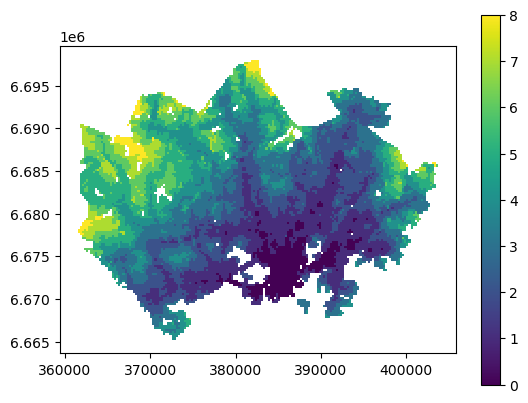

In [14]:
accessibility_grid.plot(column="nb_pt_r_tt", linewidth=0, legend=True)

And here we go, now we have a map where we have used one of the common
classifiers to classify our data into 9 classes.


## Plotting a histogram

A histogram is a graphic representation of the distribution of the data. When
classifying the data, it's always good to consider how the data is distributed,
and how the classification shceme divides values into different ranges. 

- plot the histogram using [pandas.DataFrame.plot.hist](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.hist.html)
- Number of histogram bins (groups of data) can be controlled using the parameter `bins`:

<Axes: ylabel='Frequency'>

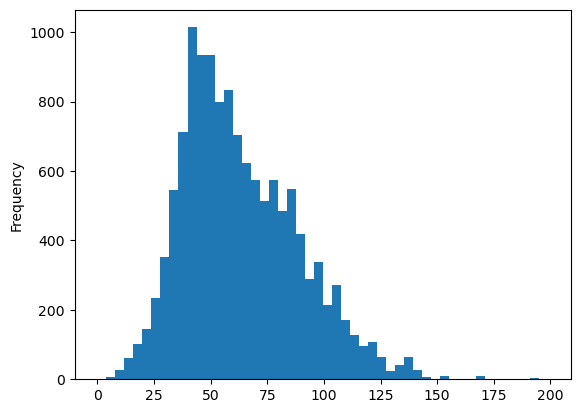

In [15]:
# Histogram for public transport rush hour travel time
accessibility_grid["pt_r_tt"].plot.hist(bins=50)

Let's also add threshold values on thop of the histogram as vertical lines.

- Natural Breaks:

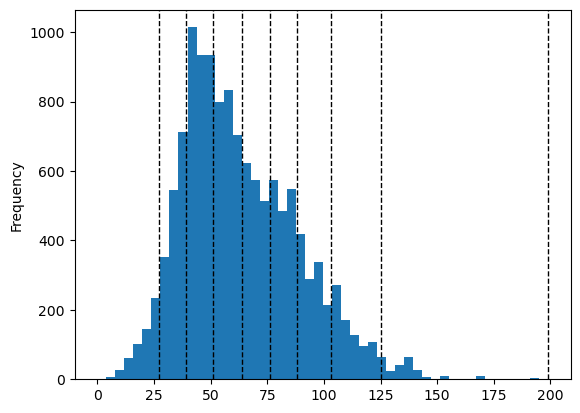

In [16]:
import matplotlib.pyplot as plt

# Define classifier
classifier = mapclassify.NaturalBreaks(y=accessibility_grid["pt_r_tt"], k=9)

# Plot histogram for public transport rush hour travel time
accessibility_grid["pt_r_tt"].plot.hist(bins=50)

# Add vertical lines for class breaks
for break_point in classifier.bins:
    plt.axvline(break_point, color="k", linestyle="dashed", linewidth=1)

- Quantiles:

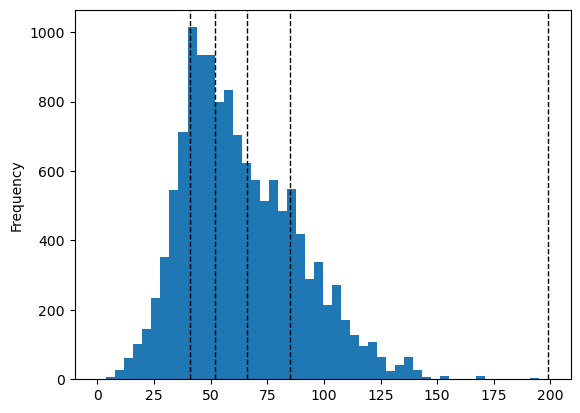

In [17]:
# Define classifier
classifier = mapclassify.Quantiles(y=accessibility_grid['pt_r_tt'])

# Plot histogram for public transport rush hour travel time
accessibility_grid["pt_r_tt"].plot.hist(bins=50)

for break_point in classifier.bins:
    plt.axvline(break_point, color="k", linestyle="dashed", linewidth=1)

:::{admonition} Check your understanding
:class: tip

Select another column from the data (for example, travel times by car:
`car_r_t`). Do the following visualizations using one of the classification
schemes available from
[pysal/mapclassify](https://github.com/pysal/mapclassify):
    
- histogram with vertical lines showing the classification bins
- thematic map using the classification scheme
:::


## Applying a custom classifier

### Multicriteria data classification



Let's classify the geometries into two classes based
on a given `threshold` -parameter. If the area of a polygon is lower than the
threshold value (e.g., a certain distance), the output column will get a value
0, if it is larger, it will get a value 1. This kind of classification is often
called a [binary
classification](https://en.wikipedia.org/wiki/Binary_classification).

To classify each row of our GeoDataFrame we can iterate over each row or we can apply
a function for each row. In our case, we will apply a [lambda function](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-1/exercise-1.html#apply-ing-an-anonymous-lambda-function) for each row in
our GeoDataFrame, which returns a value based on the conditions we provide.

Let's do our classification based on two criteria: and find out grid cells

1. Grid cells where the travel time is **lower or equal to 20 minutes** 

2. *and* they are further away **than 4 km (4000 meters)** from the city center.


Let's first see how to classify a single row:

In [18]:
accessibility_grid.iloc[0]["pt_r_tt"] < 20 and accessibility_grid.iloc[0]["walk_d"] > 4000

np.False_

In [19]:
int(accessibility_grid.iloc[11293]["pt_r_tt"] < 20 and accessibility_grid.iloc[11293]["walk_d"] > 4000)

1

Let's now apply this to our GeoDataFrame and save it to a column called `"suitable_area"`:

In [20]:
accessibility_grid["suitable_area"] = accessibility_grid.apply(lambda row: int(row["pt_r_tt"] < 20 and row["walk_d"] > 4000), axis=1)

In [21]:
accessibility_grid.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,geometry,nb_pt_r_tt,suitable_area
0,32297,43,32260,48,5785640,32616,116,147,32616,108,139,5975375,32164,459,"POLYGON ((382000 6697750, 381750 6697750, 3817...",8,0
1,32508,43,32471,49,5785641,32822,119,145,32822,111,133,5975375,29547,422,"POLYGON ((382250 6697750, 382000 6697750, 3820...",8,0
2,30133,50,31872,56,5785642,32940,121,146,32940,113,133,5975375,29626,423,"POLYGON ((382500 6697750, 382250 6697750, 3822...",8,0
3,32690,54,34429,60,5785643,33233,125,150,33233,117,144,5975375,29919,427,"POLYGON ((382750 6697750, 382500 6697750, 3825...",8,0
4,31872,42,31834,48,5787544,32127,109,126,32127,101,121,5975375,31674,452,"POLYGON ((381250 6697500, 381000 6697500, 3810...",7,0


Okey we have new values in `suitable_area` -column.

- How many Polygons are suitable for us? Let's find out by using a Pandas
  function called `value_counts()` that return the count of different values in
  our column.

In [22]:
accessibility_grid["suitable_area"].value_counts()

suitable_area
0    13011
1        9
Name: count, dtype: int64

Okay, so there seems to be nine suitable locations for us where we can try to
find an appartment to buy.

- Let's see where they are located:

<Axes: >

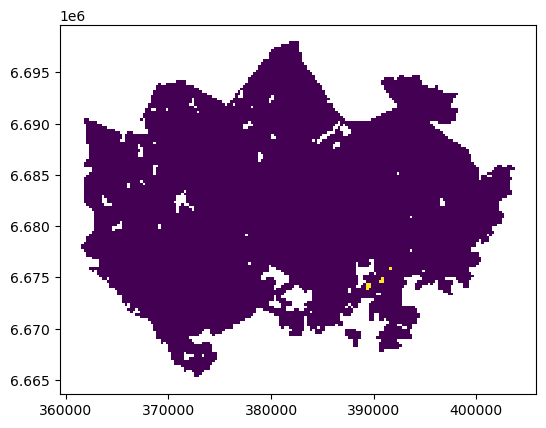

In [23]:
accessibility_grid.plot(column="suitable_area", linewidth=0)

A-haa, okay so we can see that suitable places for us with our criteria seem to
be located in the eastern part from the city center. Actually, those locations
are along the metro line which makes them good locations in terms of travel
time to city center since metro is really fast travel mode.